In [1]:
import torch, random, sys

from tqdm.notebook import tqdm

import tonic
from tonic.datasets.dvsgesture import DVSGesture
from tonic.transforms import ToFrame
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from sinabs.activation.surrogate_gradient_fn import PeriodicExponential, MultiGaussian

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../../utils')
sys.path.append('../models')

from SCNN import SCNN
# from CSNN3 import CSNN3
from train_test_fn import training_loop

In [2]:
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

## Loading Data

In [3]:
batch_size = 8
num_workers = 4
epochs = 30
lr = 5e-5

spk_thr = 2.0
v_min = -0.313

grad_scale = 1.534
grad_width = 0.759

In [4]:
root_dir = "../../DVSGESTURE"
_ = DVSGesture(save_to=root_dir, train=True)
_ = DVSGesture(save_to=root_dir, train=False)

In [5]:
n_time_steps = 50
to_raster = ToFrame(sensor_size=DVSGesture.sensor_size, n_time_bins=n_time_steps)

snn_train_dataset = DVSGesture(save_to=root_dir, train=True, transform=to_raster)
snn_test_dataset = DVSGesture(save_to=root_dir, train=False, transform=to_raster)

In [6]:
sample_data, label = snn_train_dataset[0]
print(f"The transformed array is in shape [Time-Step, Channel, Height, Width] --> {sample_data.shape}")

The transformed array is in shape [Time-Step, Channel, Height, Width] --> (50, 2, 128, 128)


disk caching samples...

In [7]:
disk_cache_train = tonic.DiskCachedDataset(
    dataset=snn_train_dataset,
    cache_path='./cached_train'
)

disk_cache_test = tonic.DiskCachedDataset(
    dataset=snn_test_dataset,
    cache_path='./cached_test'
)

In [8]:
snn_train_dataloader = DataLoader(disk_cache_train, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
snn_test_dataloader = DataLoader(disk_cache_test, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

## Network Module

We need to define a `nn.Module` implementing the network we want the chip to reproduce.

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA GeForce RTX 3070 Ti


In [10]:
snn = SCNN(DVSGesture.sensor_size, 11, batch_size, PeriodicExponential(grad_scale=grad_scale, grad_width=grad_width), v_min, spk_thr).to(device)

flat_s:  784


In [11]:
snn.init_weights()

In [12]:
optimizer = Adam(snn.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
loss_fn = CrossEntropyLoss()

## Define train and test

## Training loop (HPO)

In [13]:
epochs_x, epochs_y, epochs_acc = training_loop(
    device, 
    n_time_steps,
    batch_size,
    DVSGesture.sensor_size,
    snn_train_dataloader, 
    snn, 
    loss_fn, 
    optimizer, 
    epochs, 
    snn_test_dataloader)

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 accuracy: 14.393939393939394


  0%|          | 0/134 [00:00<?, ?it/s]

KeyboardInterrupt: 

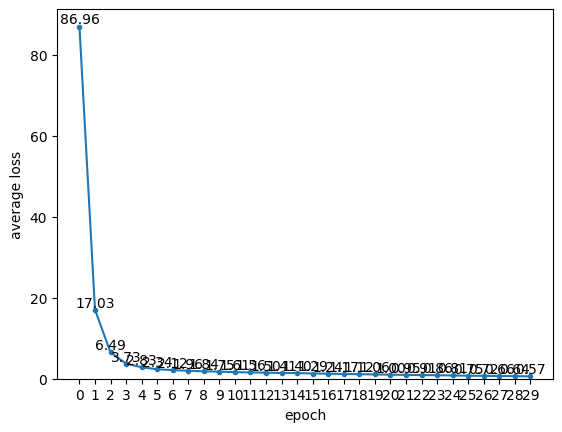

In [ ]:
y_avg = []
for y in epochs_y:
    y_avg.append(np.mean(y))

plt.plot(np.arange(len(epochs_x)), y_avg, marker = '.')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.ylim(0,)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(y_avg):
    plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()

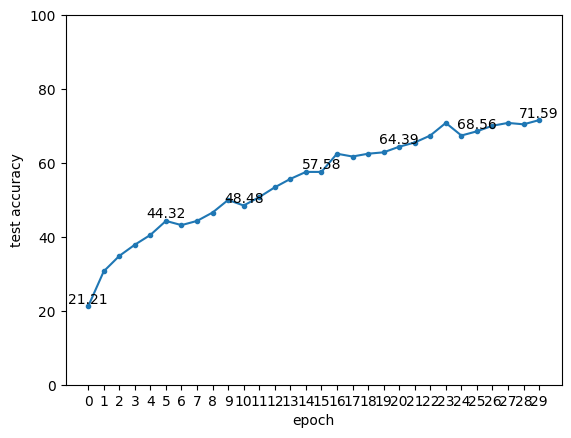

In [ ]:
plt.plot(np.arange(len(epochs_x)), epochs_acc, marker = '.')
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.ylim(0, 100)
plt.xticks(np.arange(len(epochs_x)))
for i, txt in enumerate(epochs_acc):
    if i%5 ==0 or i == epochs-1:
        plt.text(i, txt, f'{txt:.2f}', ha='center', va='bottom', color = 'k')
plt.show()